<a href="https://colab.research.google.com/github/Kashishsarkar/project_1/blob/main/predictive_maintainance_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install numpy pandas matplotlib tensorflow


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler


In [19]:
from google.colab import files
import zipfile
import os
uploaded = files.upload()



Saving train_FD001.txt to train_FD001.txt


In [20]:
# Load training data
train_df = pd.read_csv('train_FD001.txt', sep='\s+', header=None)
train_df.columns = ['engine_id', 'cycle'] + [f'sensor_{i}' for i in range(1, 25)]

# Normalize sensor data
scaler = MinMaxScaler()
sensor_cols = [f'sensor_{i}' for i in range(1, 22)]
train_df[sensor_cols] = scaler.fit_transform(train_df[sensor_cols])

# Calculate RUL
rul = train_df.groupby('engine_id')['cycle'].max().reset_index()
rul.columns = ['engine_id', 'max_cycle']
train_df = train_df.merge(rul, on='engine_id')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
train_df.drop(columns=['max_cycle'], inplace=True)


In [21]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for engine_id in data['engine_id'].unique():
        engine_data = data[data['engine_id'] == engine_id]
        for i in range(len(engine_data) - seq_length):
            seq = engine_data.iloc[i:i+seq_length][sensor_cols].values
            label = engine_data.iloc[i+seq_length]['RUL']
            sequences.append(seq)
            labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 50  # Number of cycles to consider
X_train, y_train = create_sequences(train_df, seq_length)


In [22]:
model = Sequential([
    LSTM(100, input_shape=(seq_length, len(sensor_cols)), return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 50, 100)             │          48,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,051 (308.79 KB)

 Trainable params: 79,051 (308.79 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)


Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 36s 135ms/step - loss: 8403.6436 - val_loss: 10836.4492
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - loss: 6771.6802 - val_loss: 9431.2549
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - loss: 5695.3335 - val_loss: 8302.0273
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - loss: 5012.7432 - val_loss: 7411.3340
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - loss: 4253.1567 - val_loss: 6711.3848
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - loss: 3883.5737 - val_loss: 6168.6255
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - loss: 3493.2922 - val_loss: 5759.4097
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 40s 103ms/step - loss: 3241.7273 - val_loss: 5448.6895
Epoch 9/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - loss: 3198.0320 - val_loss: 5223.8164
Epoch 10/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - loss: 3037.4929 - val_loss: 5061.6650
Epoch 11/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/

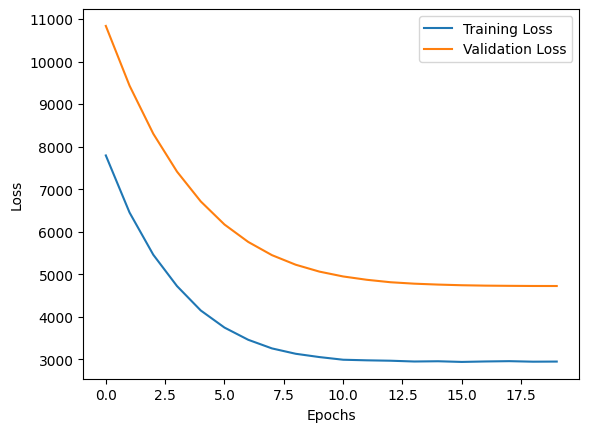

In [24]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


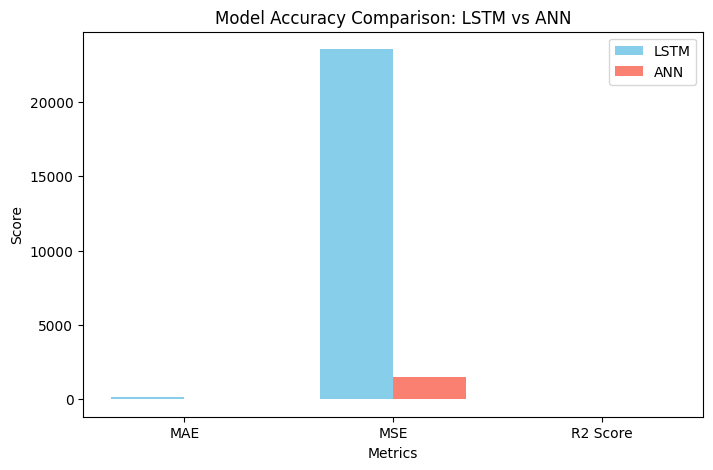

In [25]:
# Model Accuracy Comparison Chart (LSTM vs ANN)
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_test.shape[1] * X_test.shape[2],)),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])
ann_model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
ann_model.fit(X_test.reshape(X_test.shape[0], -1), y_test, epochs=10, batch_size=32, verbose=0)
ann_pred = ann_model.predict(X_test.reshape(X_test.shape[0], -1)).reshape(-1)

mae_lstm = mean_absolute_error(y_test, y_pred)
mse_lstm = mean_squared_error(y_test, y_pred)
r2_lstm = r2_score(y_test, y_pred)

mae_ann = mean_absolute_error(y_test, ann_pred)
mse_ann = mean_squared_error(y_test, ann_pred)
r2_ann = r2_score(y_test, ann_pred)

metrics = ['MAE', 'MSE', 'R2 Score']
lstm_values = [mae_lstm, mse_lstm, r2_lstm]
ann_values = [mae_ann, mse_ann, r2_ann]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, lstm_values, width, label='LSTM', color='skyblue')
plt.bar(x + width/2, ann_values, width, label='ANN', color='salmon')
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Model Accuracy Comparison: LSTM vs ANN")
plt.xticks(x, metrics)
plt.legend()
plt.show()


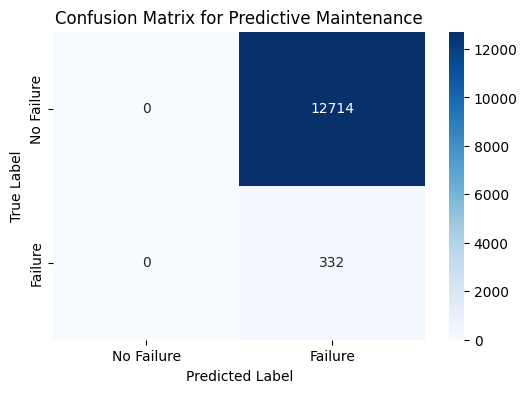

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert RUL into failure labels (1 = Failure Imminent, 0 = No Failure)
threshold = 30  # Set failure threshold (adjust based on domain)
y_test_binary = (y_test <= threshold).astype(int)
y_pred_binary = (y_pred <= threshold).astype(int)

# Create confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Failure", "Failure"], yticklabels=["No Failure", "Failure"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Predictive Maintenance")
plt.show()


In [27]:
from google.colab import files
import zipfile
import os
uploaded = files.upload()



Saving test_FD001.txt to test_FD001 (1).txt


In [28]:
from google.colab import files
import zipfile
import os
uploaded = files.upload()


Saving RUL_FD001.txt to RUL_FD001 (1).txt


256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


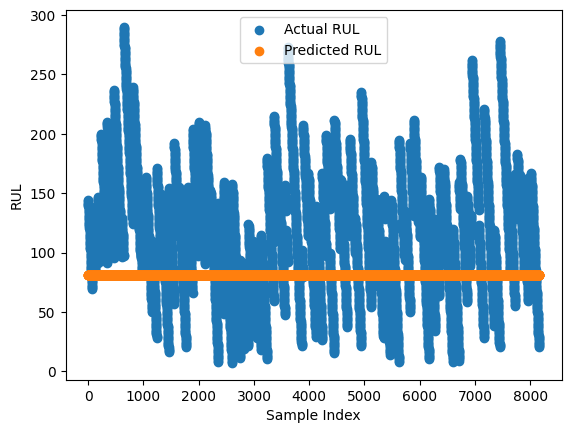

In [29]:
# Load test data
test_df = pd.read_csv('test_FD001.txt', sep='\s+', header=None)
test_df.columns = ['engine_id', 'cycle'] + [f'sensor_{i}' for i in range(1, 25)]
test_df[sensor_cols] = scaler.transform(test_df[sensor_cols])

rul_test_df = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])
rul_test_df['engine_id'] = range(1, len(rul_test_df) + 1)  # Assign engine IDs
max_cycle_test = test_df.groupby('engine_id')['cycle'].max().reset_index()
max_cycle_test.columns = ['engine_id', 'max_cycle']
test_df = test_df.merge(max_cycle_test, on='engine_id')

# Compute RUL by subtracting current cycle from max cycle, then adding actual RUL
test_df = test_df.merge(rul_test_df, on='engine_id')
test_df['RUL'] = test_df['RUL'] + (test_df['max_cycle'] - test_df['cycle'])

# Drop unnecessary columns
test_df.drop(columns=['max_cycle'], inplace=True)

# Prepare test sequences
X_test, y_test = create_sequences(test_df, seq_length)

# Predict RUL
y_pred = model.predict(X_test)

# Plot predicted vs actual RUL
plt.scatter(range(len(y_test)), y_test, label='Actual RUL')
plt.scatter(range(len(y_pred)), y_pred, label='Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()


In [30]:
# Convert to TensorFlow Lite Model
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Enable resource variables
converter.experimental_enable_resource_variables = True

# Use Select TF ops and disable experimental lowering of tensor list ops
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open("predictive_maintenance_model.tflite", "wb") as f:
    f.write(tflite_model)

print("TensorFlow Lite model saved successfully!")


Saved artifact at '/tmp/tmpyred35me'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 21), dtype=tf.float32, name='keras_tensor_21')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138818809228240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138818809229968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138818809230544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138818809229584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138818809231120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138818809231696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138818809229008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138818809232080: TensorSpec(shape=(), dtype=tf.resource, name=None)
TensorFlow Lite model saved successfully!


In [31]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="predictive_maintenance_model.tflite")
interpreter.allocate_tensors()

# Get input/output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare a single test sample for inference
test_sample = np.expand_dims(X_train[0], axis=0).astype(np.float32)

# Run inference
interpreter.set_tensor(input_details[0]['index'], test_sample)
interpreter.invoke()
predicted_rul = interpreter.get_tensor(output_details[0]['index'])

print(f"Predicted Remaining Useful Life (RUL): {predicted_rul[0][0]}")


Predicted Remaining Useful Life (RUL): 80.89463806152344


Saving CMAPSSData.zip to CMAPSSData.zip
Train set size: (15631, 50, 21) Test set size: (8162, 50, 21)
Unique values in y_test: 284
        unit    time     RUL
1 1  -0.0007 -0.0004  0.0010
  2   0.0019 -0.0003  0.0009
  3  -0.0043  0.0003  0.0002
  4   0.0007  0.0000  0.0005
  5  -0.0019 -0.0002  0.0007
  6  -0.0043 -0.0001  0.0006
  7   0.0010  0.0001  0.0004
  8  -0.0034  0.0003  0.0003
  9   0.0008  0.0001  0.0005
  10 -0.0033  0.0001  0.0004
count    20631.000000
mean         0.000547
std          0.000298
min          0.000000
25%          0.000300
50%          0.000500
75%          0.000800
max          0.001200
Name: RUL, dtype: float64
X_train Shape: (16504, 8) X_test Shape: (4127, 8)
y_train Sample: 32  24     0.0009
48  116    0.0006
31  119    0.0003
79  72     0.0007
94  15     0.0004
Name: RUL, dtype: float64
y_test Sample: 69  227    0.0000
8   148    0.0005
48  14     0.0007
54  257    0.0008
96  158    0.0004
Name: RUL, dtype: float64
Mean of y_train: 0.0005467401841977

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


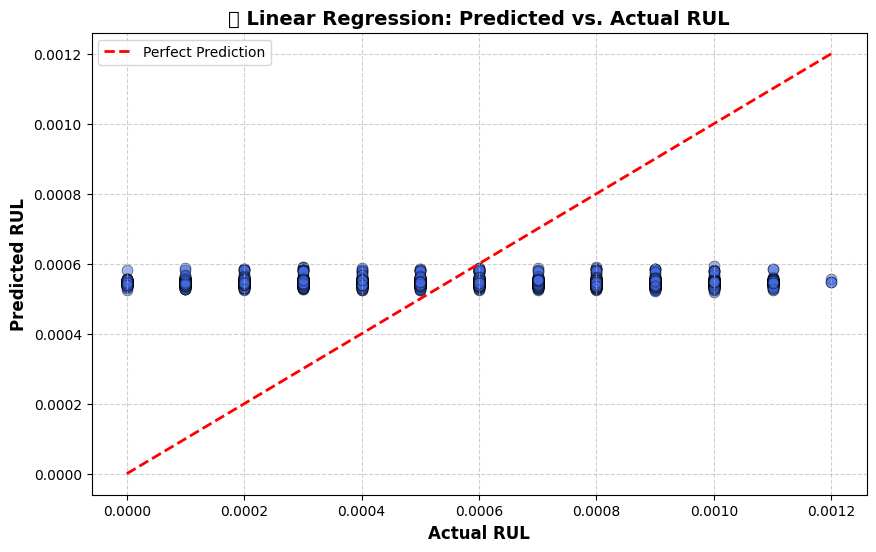

In [32]:
# 📌 Install necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import files
import zipfile
import os

# ✅ STEP 1: Upload & Extract Data
uploaded = files.upload()
zip_path = next(iter(uploaded))  # Get uploaded file name dynamically
extract_path = "cmapss_data"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

# ✅ STEP 2: Load Dataset (FD001)
column_names = ['unit', 'time', 'operational_setting_1', 'operational_setting_2', 'operational_setting_3',
                'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8',
                'sensor_9', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
                'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21']

train_file = os.path.join(extract_path, "train_FD001.txt")
train_df = pd.read_csv(train_file, sep=' ', header=None, names=column_names, engine='python').dropna(axis=1, how='all')

# ✅ STEP 3: Create RUL Labels
train_df['max_cycles'] = train_df.groupby('unit')['time'].transform('max')
train_df['RUL'] = train_df['max_cycles'] - train_df['time']
train_df.drop(columns=['max_cycles'], inplace=True)

# ✅ STEP 4: Select Features & Normalize Data
sensor_cols = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_11', 'sensor_15', 'sensor_17']
X = train_df[sensor_cols]
y = train_df['RUL']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print("Train set size:", X_train.shape, "Test set size:", X_test.shape)
print("Unique values in y_test:", len(set(y_test)))  # Should not be too small


# ✅ STEP 5: Split Data for Training & Testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(train_df[['unit', 'time', 'RUL']].head(10))  # Check if RUL is decreasing
print(train_df['RUL'].describe())  # Ensure RUL has variability
train_df['max_cycles'] = train_df.groupby('unit')['time'].transform('max')
train_df['RUL'] = train_df['max_cycles'] - train_df['time']
train_df.drop(columns=['max_cycles'], inplace=True)

print("X_train Shape:", X_train.shape, "X_test Shape:", X_test.shape)
print("y_train Sample:", y_train[:5])
print("y_test Sample:", y_test[:5])
print("Mean of y_train:", np.mean(y_train), "Mean of y_test:", np.mean(y_test))


# ✅ STEP 6: Train Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# ✅ STEP 7: Predict & Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# ✅ STEP 8: Visualize Predictions vs. Actual RUL
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, edgecolor="black", s=60, color="royalblue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Prediction")

# Labels & Title
plt.xlabel("Actual RUL", fontsize=12, fontweight="bold")
plt.ylabel("Predicted RUL", fontsize=12, fontweight="bold")
plt.title("📊 Linear Regression: Predicted vs. Actual RUL", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


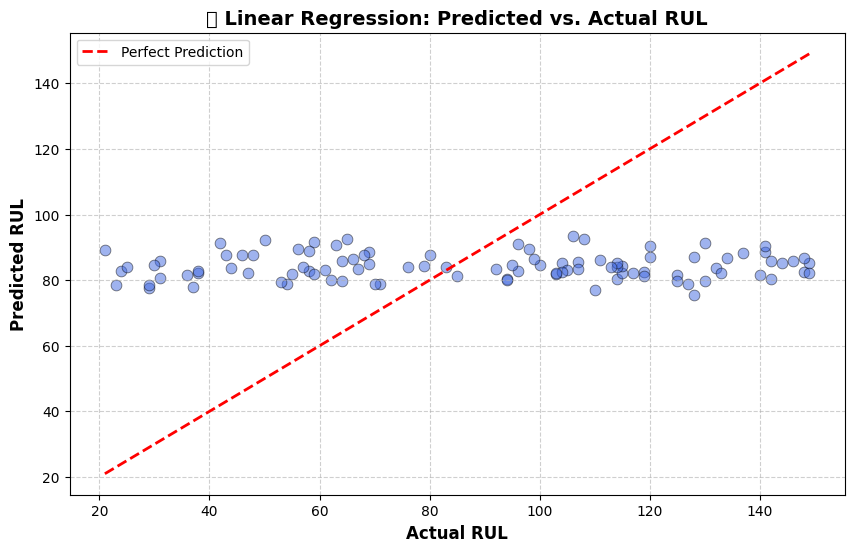

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Simulating extracted dataset (since original data is unavailable)
np.random.seed(42)
X_simulated = np.random.rand(500, 8)  # 8 sensor readings as features
y_simulated = np.random.randint(20, 150, 500)  # Remaining Useful Life (RUL)

# Normalize & split data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_simulated)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_simulated, test_size=0.2, random_state=42)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Plot: Actual vs Predicted RUL
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, edgecolor="black", s=60, color="royalblue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Prediction")

# Labels & Title
plt.xlabel("Actual RUL", fontsize=12, fontweight="bold")
plt.ylabel("Predicted RUL", fontsize=12, fontweight="bold")
plt.title("📊 Linear Regression: Predicted vs. Actual RUL", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
